In [1]:
from svi import *
from essvi import *
from heston import *

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["mathtext.fontset"] = "cm"   
mpl.rcParams["mathtext.rm"] = "serif" 

## I. Slice-by-slice calibration 

### I.1. Sanity check 

In [82]:
n = 150

a_true, b_true, m_true, rho_true, sigma_true = (0.04, 0.1, 0.0, -0.5, 0.3)
#a_true, b_true, m_true, rho_true, sigma_true = (0.04, 0.1, 0.0, -0.5, 0.01) # more skewed 
#a_true, b_true, m_true, rho_true, sigma_true = (0.001, 0.6, -0.5, 0.07, 0.1) # with butterfly spread arbitrage 

T = 1
k = np.linspace(-1.5, 1.5, n)
var = svi_raw(k, a_true, b_true, m_true, rho_true, sigma_true)
vega = np.ones_like(k)

svi = SVI(k, var, vega, T)
a_calib, b_calib, m_calib, rho_calib, sigma_calib = svi.calibration(rounded=False, without_butterfly_arbitrage=True)

In [84]:
a_naive, b_naive, m_naive, rho_naive, sigma_naive, loss = naive_calibration_SVI(k, var, T, M = 1) 

Calibration: 100%|████████████████████████████████| 1/1 [00:00<00:00,  8.43it/s]


In [86]:
print("Quasi-Explicit parameters : ", a_calib, b_calib, m_calib, rho_calib, sigma_calib)
print("Naive parameters : ",a_naive, b_naive, m_naive, rho_naive, sigma_naive)

Quasi-Explicit parameters :  0.03999999999999996 0.10000000000000006 -3.513221968452327e-16 -0.5000000000000001 0.30000000000000054
Naive parameters :  0.004427967853738203 0.11784773680280757 0.18085645327720917 -0.2651741815479336 0.5125369901388785


In [88]:
print("MSE (Quasi-Explicit calibration) =", svi.MSE(a_calib, b_calib, m_calib, rho_calib, sigma_calib))
print("MSE (Naive calibration) =", loss)

MSE (Quasi-Explicit calibration) = 8.050387167538646e-32
MSE (Naive calibration) = 0.003337033645331295


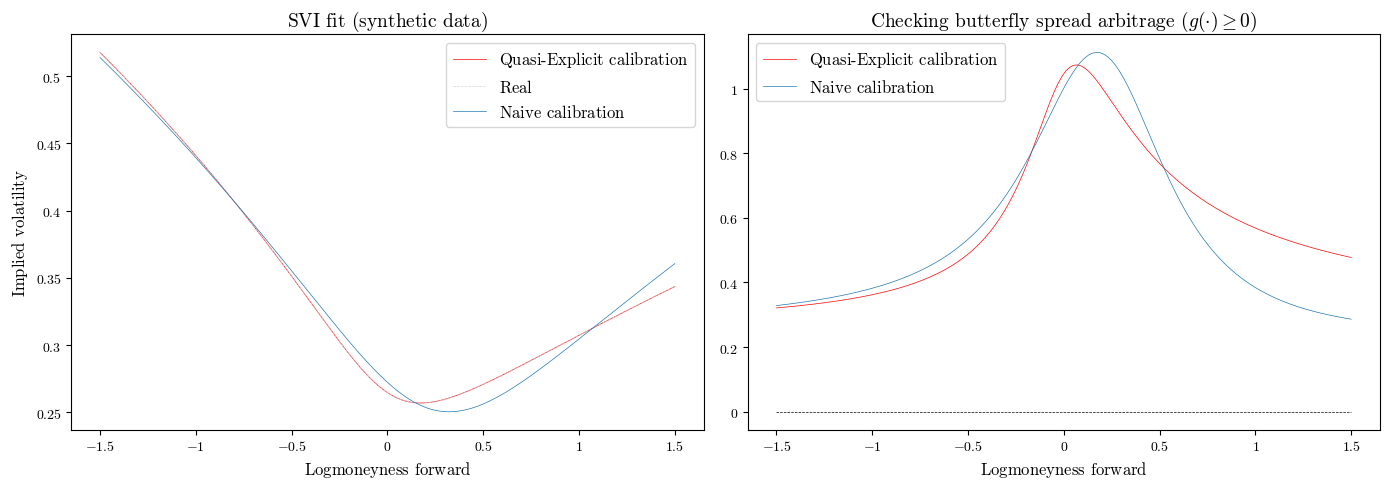

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(7*2,5))
ax[0].plot(k, np.sqrt(svi_raw(k, a_calib, b_calib, m_calib, rho_calib, sigma_calib)), lw = 0.5, color = "red", label = r"$\text{Quasi-Explicit calibration}$")
ax[0].plot(k, np.sqrt(svi_raw(k, a_true, b_true, m_true, rho_true, sigma_true)), lw=0.5, linestyle ="--", color = "lightgray", label = r"$\text{Real}$")
ax[0].plot(k, np.sqrt(svi_raw(k, a_naive, b_naive, m_naive, rho_naive, sigma_naive)), lw=0.5, label = r"$\text{Naive calibration}$")
ax[0].set_xlabel(r"$\text{Logmoneyness forward}$", fontsize=12)
ax[0].set_ylabel(r"$\text{Implied volatility}$", fontsize=12)
ax[0].legend(fontsize=12)
ax[0].xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
ax[0].yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
ax[0].set_title(r"$\text{SVI fit (synthetic data)}$", fontsize=14)

ax[1].plot(k, durrleman_condition(k, a_calib, b_calib, m_calib, rho_calib, sigma_calib), lw = 0.5, color = "red", label =r"$\text{Quasi-Explicit calibration}$")
ax[1].plot(k, durrleman_condition(k, a_naive, b_naive, m_naive, rho_naive, sigma_naive), lw = 0.5, label =r"$\text{Naive calibration}$")
ax[1].plot(k, np.zeros_like(k), lw = 0.5, color = "black", linestyle="--")

ax[1].set_xlabel(r"$\text{Logmoneyness forward}$", fontsize=12)
ax[1].legend(fontsize=12)
ax[1].xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
ax[1].yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
ax[1].set_title(r"$\text{Checking butterfly spread arbitrage (} g(\cdot)\geq0\text{)}$", fontsize=14)
fig.tight_layout()
plt.show()

### I.2. Remove butterfly spread arbitrage opportunity : the Vogt's case 

In [74]:
a, b, m, rho, sigma = (-0.041, 0.1331, 0.3586, 0.306, 0.4153)
k = np.linspace(-1.5, 1.5, 150)
T = 1
var = svi_raw(k, a, b, m, rho, sigma) 
vega = np.ones_like(k)
svi = SVI(k, var, vega, T) 

In [76]:
# The "naive" way to remove butterfly arbitrage: 
v, psi, p, c, hat_v = from_raw_to_jw_parametrization(a, b, m, rho, sigma, T)
print(v, psi, p, c, hat_v)
c_tilde = p + 2 * psi
hat_v_tilde = v * 4 * p * c_tilde / (p + c_tilde)**2 
print(c_tilde, hat_v_tilde)
a_tilde, b_tilde, m_tilde, rho_tilde, sigma_tilde = from_jv_to_raw_parametrization(v, psi, p, c_tilde, hat_v_tilde, T)

0.017426252555159116 -0.1752111408091251 0.6997381041168087 1.3167982189863865 0.011624903235477872
0.3493158224985585 0.015481824840731183


In [78]:
# The "optimal" way to remove butterfly arbitrage: 
a_af, b_af, m_af, rho_af, sigma_af = svi.remove_butterfly_arbitrage(a, b, m, rho, sigma)

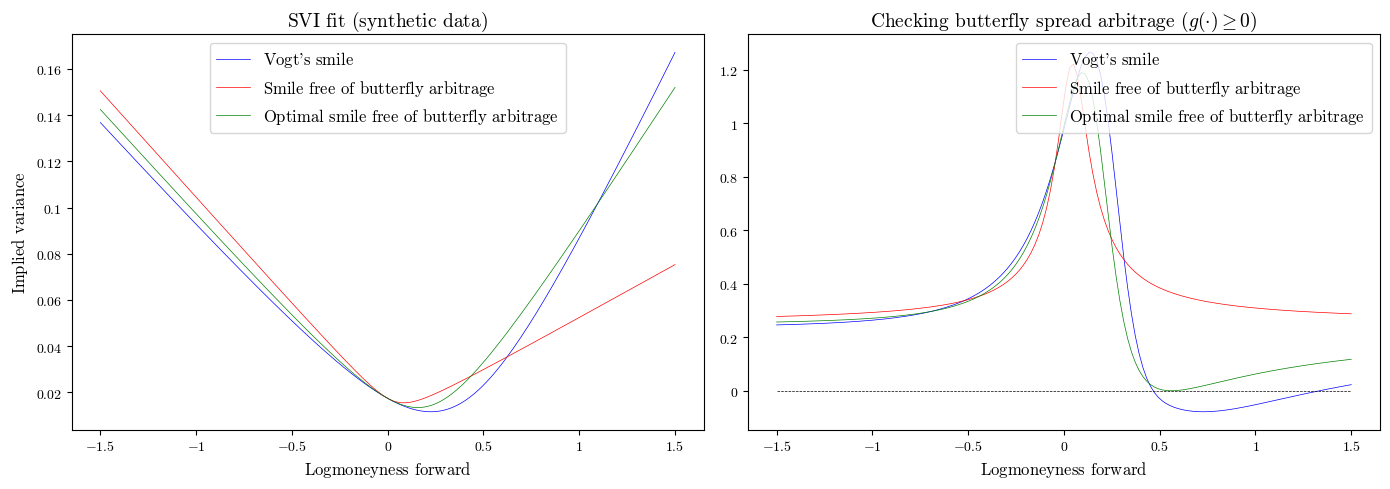

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(7*2,5))
ax[0].plot(k, svi_raw(k, a, b, m, rho, sigma), lw = 0.5, color = "blue", label = r"$\text{Vogt's smile}$")
ax[0].plot(k, svi_jw(k, v, psi, p, c_tilde, hat_v_tilde, T), lw = 0.5, color = "red", label = r"$\text{Smile free of butterfly arbitrage}$")
ax[0].plot(k, svi_raw(k, a_af, b_af, m_af, rho_af, sigma_af), lw = 0.5, color = "green", label = r"$\text{Optimal smile free of butterfly arbitrage}$")
ax[0].set_xlabel(r"$\text{Logmoneyness forward}$", fontsize=12)
ax[0].set_ylabel(r"$\text{Implied variance}$", fontsize=12)
ax[0].legend(fontsize=12)
ax[0].xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
ax[0].yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
ax[0].set_title(r"$\text{SVI fit (synthetic data)}$", fontsize=14)

ax[1].plot(k, durrleman_condition(k, a, b, m, rho, sigma), lw = 0.5, color = "blue", label = r"$\text{Vogt's smile}$")
ax[1].plot(k, durrleman_condition(k, a_tilde, b_tilde, m_tilde, rho_tilde, sigma_tilde), lw = 0.5, color = "red", label = r"$\text{Smile free of butterfly arbitrage}$")
ax[1].plot(k, durrleman_condition(k, a_af, b_af, m_af, rho_af, sigma_af), lw = 0.5, color = "green", label = r"$\text{Optimal smile free of butterfly arbitrage}$")
ax[1].plot(k, np.zeros_like(k), lw = 0.5, color = "black", linestyle="--")

ax[1].set_xlabel(r"$\text{Logmoneyness forward}$", fontsize=12)
ax[1].legend(fontsize=12)
ax[1].xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
ax[1].yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
ax[1].set_title(r"$\text{Checking butterfly spread arbitrage (} g(\cdot)\geq0\text{)}$", fontsize=14)

fig.tight_layout()
plt.show()

### I.3. Test on exogenous model (Heston)

In [447]:
S0, V0, r, kappa, theta, nu, rho = 1, 0.04, 0, 1.5, 0.04, 1.5, -0.75 # r = 0 (so as not to be bothered by forwards)
T_range = np.array([0.5, 1, 2])
K_range = np.array([
    np.linspace(0.80, 1.20, 30),
    np.linspace(0.80, 1.20, 30),
    np.linspace(0.80, 1.20, 30)])
IVs = np.zeros((len(T_range), len(K_range[0])))
for i, T in enumerate(T_range) : 
    IVs[i,:] = generate_IV_Heston(T, K_range[i], S0, V0, r, kappa, theta, nu, rho)

100%|██████████████████████████████████████████| 30/30 [00:00<00:00, 127.80it/s]


In [457]:
params = []
for i, T in enumerate(T_range) : 
    k = np.log(K_range[i])
    var = IVs[i]**2
    vega = np.ones_like(k)
    svi = SVI(k, var, vega, T)
    a_calib, b_calib, m_calib, rho_calib, sigma_calib = svi.calibration(lower_sigma = 0.01, rounded = True)
    MSE = svi.MSE(a_calib, b_calib, m_calib, rho_calib, sigma_calib)
    params.append([a_calib, b_calib, m_calib, rho_calib, sigma_calib, MSE])
    
params = np.array(params)
params[:, -1]

array([9.90603164e-07, 3.49890708e-07, 4.68071254e-08])

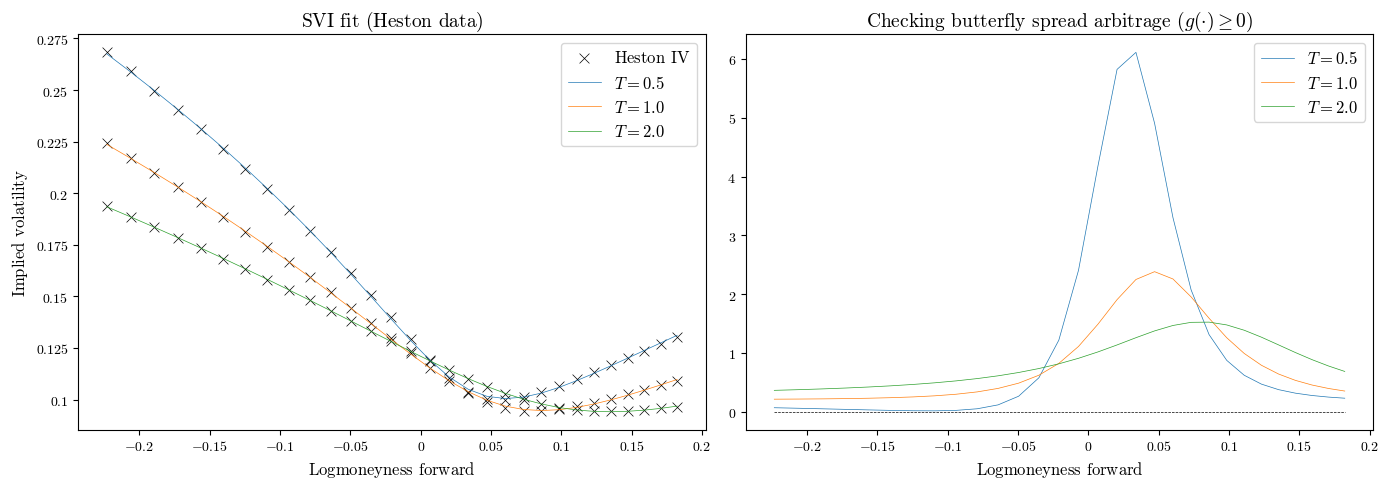

In [477]:
fig, ax = plt.subplots(1, 2, figsize=(7*2,5))
for i, T in enumerate(T_range) : 
    ax[0].scatter(np.log(K_range[i]), IVs[i,:], label = r"$\text{Heston IV}$", color = "black", marker="x", s = 50, lw = 0.5) if i == 0 else ax[0].scatter(np.log(K_range[i]), IVs[i,:], color = "black", marker="x", s = 50, lw = 0.5)
    ax[0].plot(np.log(K_range[i]), np.sqrt(svi_raw(np.log(K_range[i]), params[i, 0], params[i, 1], params[i, 2], params[i, 3], params[i, 4])), lw = 0.5, label = fr"$T = {T}$")
    ax[1].plot(np.log(K_range[i]), durrleman_condition(np.log(K_range[i]), params[i, 0], params[i, 1], params[i, 2], params[i, 3], params[i, 4]), lw = 0.5, label = fr"$T = {T}$")                            
ax[0].set_xlabel(r"$\text{Logmoneyness forward}$", fontsize=12)
ax[0].set_ylabel(r"$\text{Implied volatility}$", fontsize=12)
ax[0].legend(fontsize=12)

ax[0].xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
ax[0].yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
ax[0].set_title(r"$\text{SVI fit (Heston data)}$", fontsize=14)


ax[1].plot(k, np.zeros_like(k), lw = 0.5, color = "black", linestyle="--")
ax[1].set_xlabel(r"$\text{Logmoneyness forward}$", fontsize=12)
ax[1].legend(fontsize=12)
ax[1].xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
ax[1].yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
ax[1].set_title(r"$\text{Checking butterfly spread arbitrage (} g(\cdot)\geq0\text{)}$", fontsize=14)

fig.tight_layout()
plt.show()

### I.4. Test on market data (DAX) 

In [5]:
df = pd.read_csv("DAX.csv") ## DAX 2008 (Stripped from the DeMarco's PhD Thesis) 
maturities = df["Maturity"].unique()
dfs = []
params = np.zeros((len(maturities), 5))
for i, T in enumerate(maturities): 
    sub_df = df[df["Maturity"] == maturities[i]]
    dfs.append(sub_df)
    k = sub_df["LogmoneynessForward"]
    var = sub_df["ImpliedVolatility"]**2 
    vega = np.ones_like(k)
    svi = SVI(k, var, vega, T)
    params[i] = svi.calibration(rounded=False, without_butterfly_arbitrage=False)

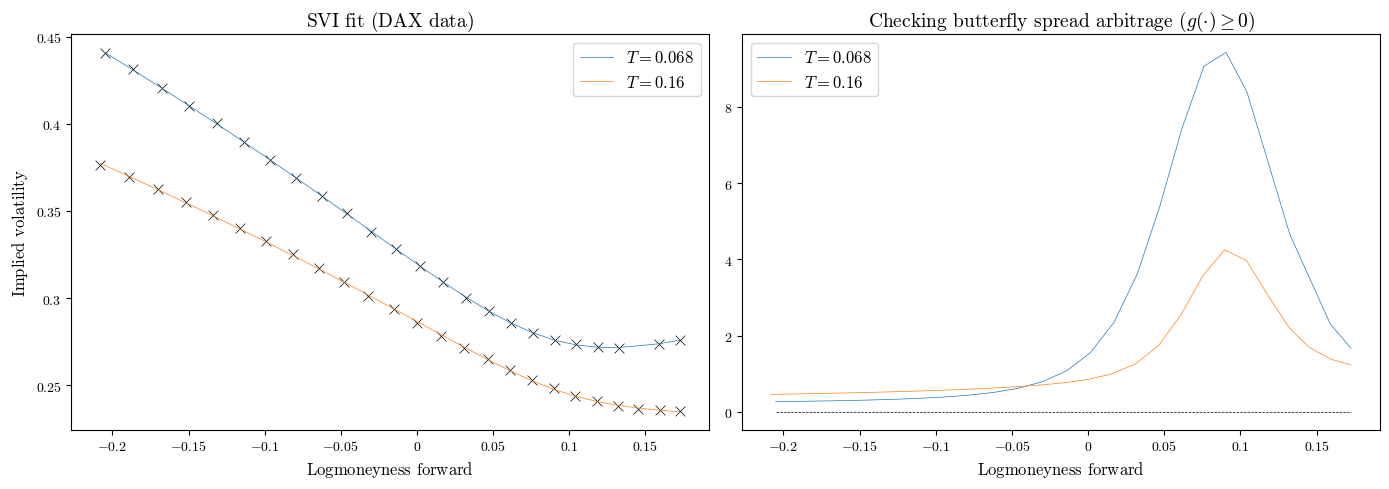

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(7*2,5))
ax[0].plot(dfs[0]["LogmoneynessForward"], np.sqrt(svi_raw(dfs[0]["LogmoneynessForward"], params[0, 0], params[0, 1], params[0, 2], params[0, 3], params[0, 4])), lw = 0.5, label = r"$T = 0.068$")
ax[0].scatter(dfs[0]["LogmoneynessForward"], dfs[0]["ImpliedVolatility"], color = "black", marker="x", s = 50, lw = 0.5)
ax[0].plot(dfs[1]["LogmoneynessForward"], np.sqrt(svi_raw(dfs[1]["LogmoneynessForward"], params[1, 0], params[1, 1], params[1, 2], params[1, 3], params[1, 4])), lw = 0.5, label = r"$T = 0.16$")
ax[0].scatter(dfs[1]["LogmoneynessForward"], dfs[1]["ImpliedVolatility"], color = "black", marker="x", s = 50, lw = 0.5)
ax[0].set_xlabel(r"$\text{Logmoneyness forward}$", fontsize=12)
ax[0].set_ylabel(r"$\text{Implied volatility}$", fontsize=12)
ax[0].legend(fontsize=12)
ax[0].xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
ax[0].yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
ax[0].set_title(r"$\text{SVI fit (DAX data)}$", fontsize=14)

ax[1].plot(dfs[0]["LogmoneynessForward"], np.zeros(len(dfs[0]["LogmoneynessForward"])), lw = 0.5, color = "black", linestyle="--")
ax[1].plot(dfs[0]["LogmoneynessForward"], durrleman_condition(dfs[0]["LogmoneynessForward"], params[0, 0], params[0, 1], params[0, 2], params[0, 3], params[0, 4]), lw = 0.5, label = r"$T = 0.068$")
ax[1].plot(dfs[1]["LogmoneynessForward"], durrleman_condition(dfs[1]["LogmoneynessForward"], params[1, 0], params[1, 1], params[1, 2], params[1, 3], params[1, 4]), lw = 0.5, label = r"$T = 0.16$")
ax[1].set_xlabel(r"$\text{Logmoneyness forward}$", fontsize=12)
ax[1].legend(fontsize=12)
ax[1].xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
ax[1].yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
ax[1].set_title(r"$\text{Checking butterfly spread arbitrage (} g(\cdot)\geq0\text{)}$", fontsize=14)

plt.tight_layout()
plt.show()

### I.5. Test on market data (VIX)

In [57]:
from py_vollib.black_scholes.implied_volatility import implied_volatility
from scipy.stats import norm

def safe_implied_volatility(price, S, K, t, r, flag):
    try:
        return implied_volatility(price, S, K, t, r, flag)
    except Exception:
        return np.nan
        
def compute_implied_vol(row):
    flag = "c" if row["CallPut"] == "C" else "p"
    iv_bid = safe_implied_volatility(row["BestBid"], row["ForwardPrice"], row["Strike"], row["Maturity"], 0, flag)    
    iv_ask = safe_implied_volatility(row["BestOffer"], row["ForwardPrice"], row["Strike"], row["Maturity"], 0, flag)
    iv_mid = 0.5 * (iv_ask + iv_bid) 
    return pd.Series([iv_bid, iv_ask, iv_mid])

def compute_vega(row) : 
    d1 = (np.log(row["ForwardPrice"] / row["Strike"]) + 0.5 * row["IV_Mid"]**2 * row["Maturity"]) / (row["IV_Mid"] * np.sqrt(row["Maturity"]))
    return pd.Series([row["ForwardPrice"] * np.sqrt(row["Maturity"]) * norm.pdf(d1)])

In [55]:
VIX_df = pd.read_csv("VIX.csv", sep = ",") # due to licensig restrictions, this dataset can't be publicy released 
VIX_df['Date'] = pd.to_datetime(VIX_df['Date'], errors='coerce')
VIX_df['Expiration'] = pd.to_datetime(VIX_df['Expiration'], errors='coerce')
VIX_df['TimeToExpiration'] = (VIX_df['Expiration'] - VIX_df['Date']).dt.days 
VIX_df['Maturity'] = (VIX_df['Expiration'] - VIX_df['Date']).dt.days / 365
VIX_df.drop(columns=['Date', 'Expiration'], inplace=True)
VIX_df['Strike'] /= 1000
VIX_df["Logmoneyness"] = -np.log(VIX_df["ForwardPrice"] / VIX_df["Strike"])
VIX_df[["IV_Bid", "IV_Ask", "IV_Mid"]] = VIX_df.apply(compute_implied_vol, axis=1)
VIX_df["Var_Bid"] = VIX_df["IV_Bid"]**2 
VIX_df["Var_Mid"] = VIX_df["IV_Mid"]**2 
VIX_df["Var_Ask"] = VIX_df["IV_Ask"]**2 
VIX_df = VIX_df.sort_values(by = "Strike")
VIX_df = VIX_df[VIX_df["CallPut"] == "C"]

VIX_df[["Vega_Mid"]] = VIX_df.apply(compute_vega, axis=1)

VIX_df = VIX_df.dropna()
maturities = VIX_df["Maturity"].unique()
maturities.sort()

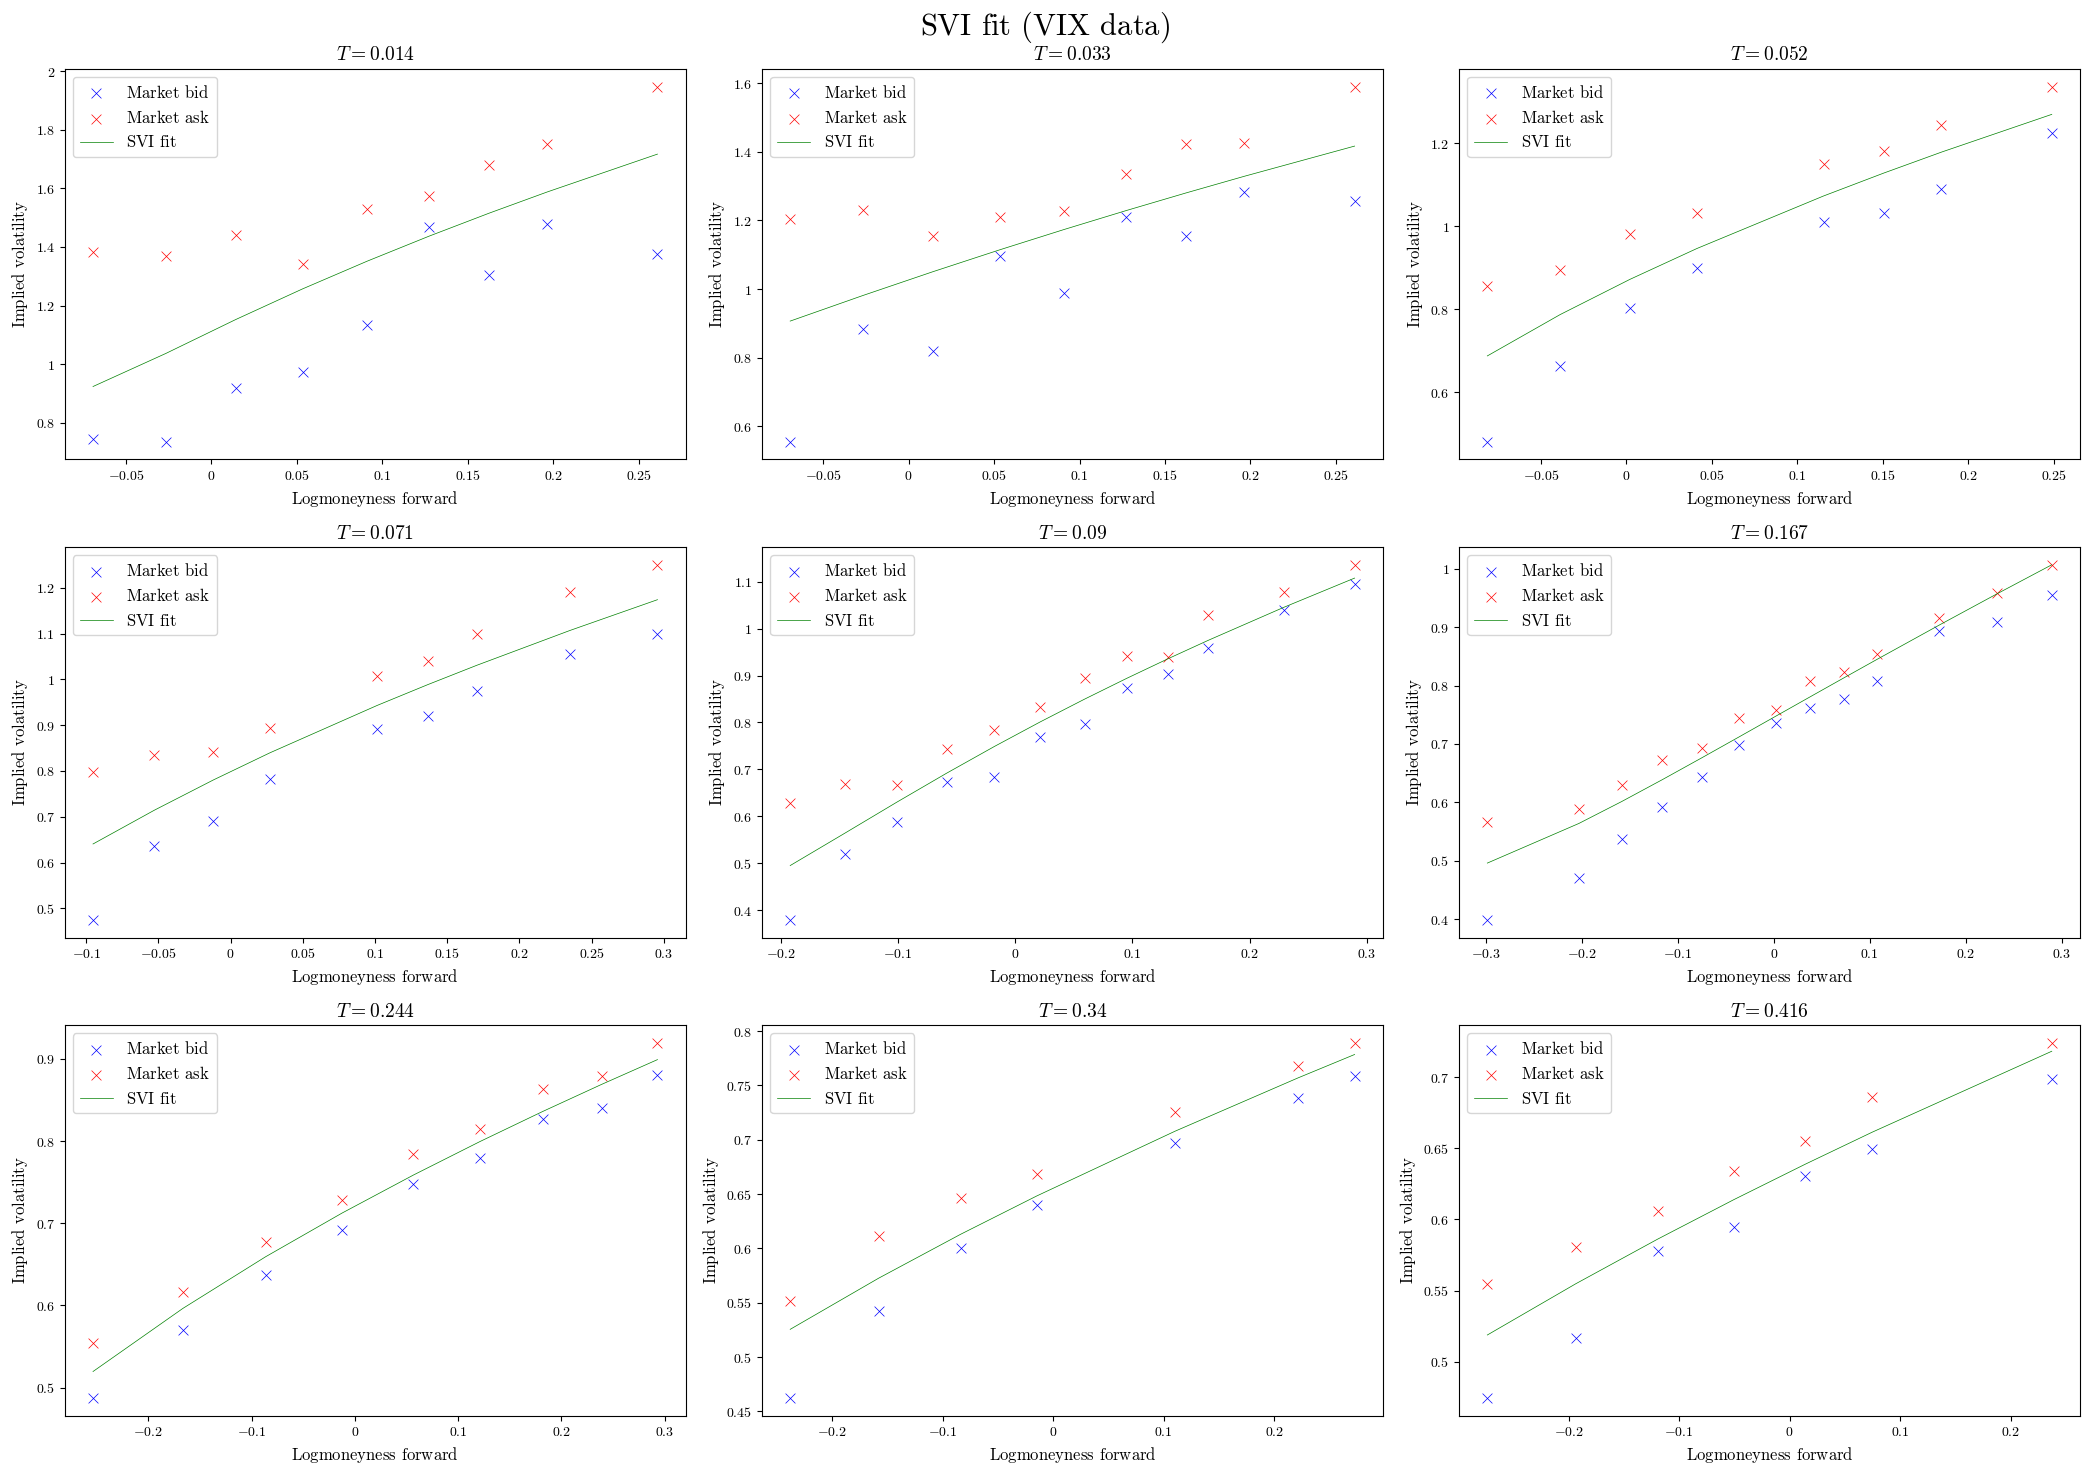

In [61]:
fig, ax = plt.subplots(3, 3, figsize=(7*3, 5*3))
ax = ax.flatten()

for i in range(len(maturities)) : 
    df = VIX_df[VIX_df["Maturity"] == maturities[i]] if i != 2 else VIX_df[VIX_df["Maturity"] == maturities[i]][1:]
    df = df[np.abs(df["Logmoneyness"]) <= 0.3]
    k = df["Logmoneyness"]
    T = np.round(maturities[i], 3)
    var = df["IV_Mid"]**2
    vega = np.ones_like(k)

    svi = SVI(k, var, vega, T)
    
    a_calib, b_calib, m_calib, rho_calib, sigma_calib = svi.calibration(m = None, sigma = None, lower_sigma = 0.005, rounded = False, without_butterfly_arbitrage = True)
    
    ax[i].scatter(k, df["IV_Bid"], color = "blue", marker="x", s = 50, lw = 0.5, label = r"$\text{Market bid}$")
    ax[i].scatter(k, df["IV_Ask"], color = "red", marker="x", s = 50, lw = 0.5, label = r"$\text{Market ask}$")
    ax[i].plot(k, np.sqrt(svi_raw(k, a_calib, b_calib, m_calib, rho_calib, sigma_calib)), lw = 0.5, color = "green", label = r"$\text{SVI fit}$")
    ax[i].set_xlabel(r"$\text{Logmoneyness forward}$", fontsize=12)
    ax[i].set_ylabel(r"$\text{Implied volatility}$", fontsize=12)
    ax[i].set_title(fr"$T = {T}$", fontsize=14)
    ax[i].legend(fontsize=12, loc = "upper left")
        
    ax[i].xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
    ax[i].yaxis.set_major_formatter(lambda y, _: f"${y:g}$")

fig.suptitle(r"$\text{SVI fit (VIX data)}$", fontsize=22)
plt.tight_layout()
plt.show()

## II. Multi-Slices SVI calibration

### II.1) Heston model 

In [11]:
S0, V0, r, kappa, theta, nu, rho = 1, 0.04, 0, 1.5, 0.04, 1.5, -0.75 # r = 0 (so as not to be bothered by forwards)
T_range = np.array([0.5, 1, 2, 5])
K_range = np.array([
    np.linspace(0.80, 1.20, 30),
    np.linspace(0.80, 1.20, 30),
    np.linspace(0.80, 1.20, 30),
    np.linspace(0.80, 1.20, 30),])
IVs = np.zeros((len(T_range), len(K_range[0])))
for i, T in enumerate(T_range) : 
    IVs[i,:] = generate_IV_Heston(T, K_range[i], S0, V0, r, kappa, theta, nu, rho)

100%|██████████████████████████████████████████| 30/30 [00:00<00:00, 154.93it/s]


In [13]:
vega_ = np.ones_like(K_range[0])
var = np.column_stack((IVs[0]**2, IVs[1]**2, IVs[2]**2, IVs[3]**2)).T
vega = np.column_stack((vega_, vega_, vega_, vega_)).T

multisvi = MultiSlicesSVI(np.log(K_range[0]), var, vega, T_range)

result = multisvi.calibration(rounded = False, without_butterfly_arbitrage = True, without_calendar_arbitrage = True)

In [14]:
print("MSEs = ", result[:, -1])

MSEs =  [9.90295195e-07 3.49877764e-07 4.67815659e-08 1.14136742e-09]


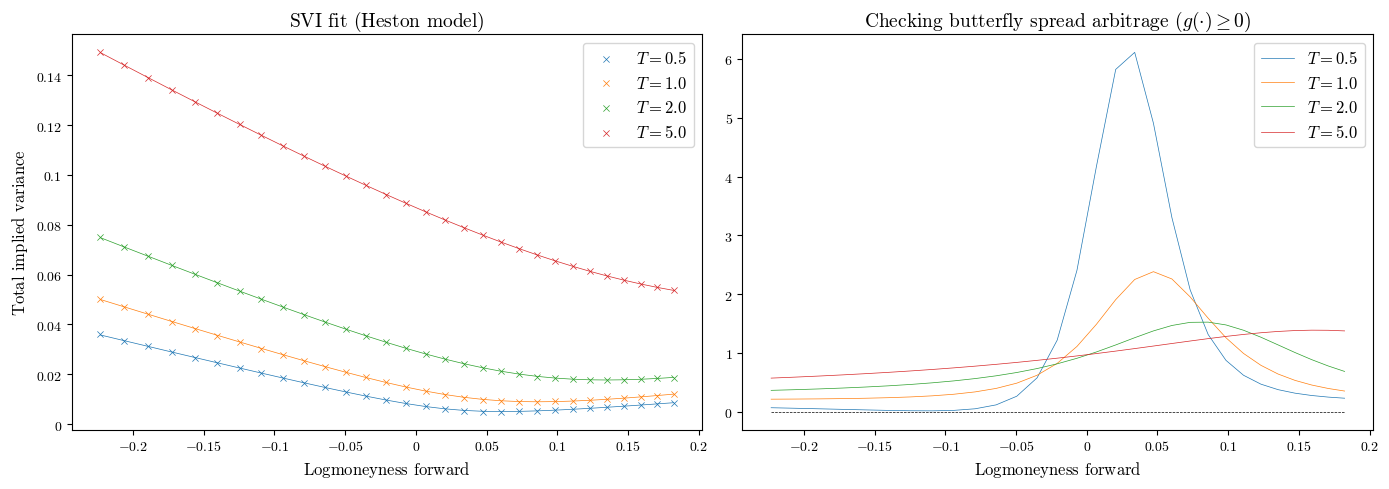

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(7 * 2, 5))
ax[0].scatter(np.log(K_range[0]), T_range[0] * IVs[0,:]**2, marker = "x", s = 20, lw = 0.5, label = fr"$T = {T_range[0]}$")
ax[0].plot(np.log(K_range[0]), T_range[0] * svi_raw(np.log(K_range[0]), result[0, 0], result[0, 1], result[0, 2], result[0, 3], result[0, 4]), lw = 0.5)
ax[0].scatter(np.log(K_range[0]), T_range[1] * IVs[1,:]**2, marker = "x", s = 20, lw = 0.5, label = fr"$T = {T_range[1]}$")
ax[0].plot(np.log(K_range[0]), T_range[1] * svi_raw(np.log(K_range[0]), result[1, 0], result[1, 1], result[1, 2], result[1, 3], result[1, 4]), lw = 0.5)
ax[0].scatter(np.log(K_range[0]), T_range[2] * IVs[2,:]**2, marker = "x", s = 20, lw = 0.5, label = fr"$T = {T_range[2]}$")
ax[0].plot(np.log(K_range[0]), T_range[2] * svi_raw(np.log(K_range[0]), result[2, 0], result[2, 1], result[2, 2], result[2, 3], result[2, 4]), lw = 0.5)
ax[0].scatter(np.log(K_range[0]), T_range[3] * IVs[3,:]**2, marker = "x", s = 20, lw = 0.5, label = fr"$T = {T_range[3]}$")
ax[0].plot(np.log(K_range[0]), T_range[3] * svi_raw(np.log(K_range[0]), result[3, 0], result[3, 1], result[3, 2], result[3, 3], result[3, 4]), lw = 0.5)
ax[0].set_xlabel(r"$\text{Logmoneyness forward}$", fontsize=12)
ax[0].set_ylabel(r"$\text{Total implied variance}$", fontsize=12)
ax[0].set_title(r"$\text{SVI fit (Heston model)}$", fontsize=14)
ax[0].legend(fontsize=12)
ax[0].xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
ax[0].yaxis.set_major_formatter(lambda y, _: f"${y:g}$")

ax[1].plot(np.log(K_range[0]), durrleman_condition(np.log(K_range[0]), result[0, 0], result[0, 1], result[0, 2], result[0, 3], result[0, 4]), lw = 0.5, label = fr"$T = {T_range[0]}$")
ax[1].plot(np.log(K_range[0]), durrleman_condition(np.log(K_range[0]), result[1, 0], result[1, 1], result[1, 2], result[1, 3], result[1, 4]), lw = 0.5, label = fr"$T = {T_range[1]}$")
ax[1].plot(np.log(K_range[0]), durrleman_condition(np.log(K_range[0]), result[2, 0], result[2, 1], result[2, 2], result[2, 3], result[2, 4]), lw = 0.5, label = fr"$T = {T_range[2]}$")
ax[1].plot(np.log(K_range[0]), durrleman_condition(np.log(K_range[0]), result[3, 0], result[3, 1], result[3, 2], result[3, 3], result[3, 4]), lw = 0.5, label = fr"$T = {T_range[3]}$")
ax[1].plot(np.log(K_range[0]), np.zeros_like(np.log(K_range[0])), lw = 0.5, color = "black", linestyle="--")
ax[1].set_xlabel(r"$\text{Logmoneyness forward}$", fontsize=12)
ax[1].legend(fontsize=12)
ax[1].xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
ax[1].yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
ax[1].set_title(r"$\text{Checking butterfly spread arbitrage (} g(\cdot)\geq0\text{)}$", fontsize=14)

plt.tight_layout()
plt.show()

### II. 2) S&P ASX 200 

In [320]:
df = pd.read_csv("SP.csv")
maturities = df["Maturity"].unique()

sub_df_1 = df[df["Maturity"] == maturities[0]] 
sub_df_2 = df[df["Maturity"] == maturities[1]] 
sub_df_3 = df[df["Maturity"] == maturities[2]] 
sub_df_4 = df[df["Maturity"] == maturities[3]] 

k = sub_df_1["LogmoneynessForward"]
k = np.array(k)
vega_ = np.ones_like(k)
var = np.column_stack((sub_df_1["ImpliedVolatility"]**2, sub_df_2["ImpliedVolatility"]**2, sub_df_3["ImpliedVolatility"]**2, sub_df_4["ImpliedVolatility"]**2)).T
vega = np.column_stack((vega_, vega_, vega_, vega_)).T

multisvi = MultiSlicesSVI(k, var, vega, maturities)
result = multisvi.calibration(rounded = False, without_butterfly_arbitrage = False, without_calendar_arbitrage = False)

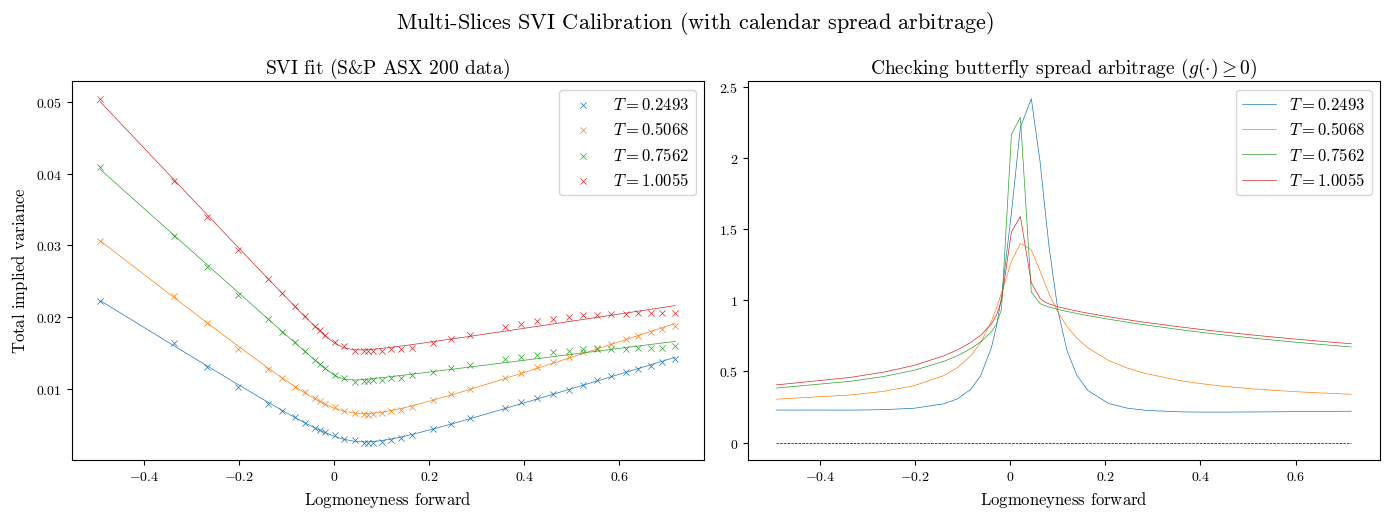

In [25]:
fig, ax = plt.subplots(1, 2, figsize = (7*2, 5.25))

ax[0].scatter(k, maturities[0] * sub_df_1["ImpliedVolatility"]**2, lw = 0.5, marker = "x", s = 20, label = fr"$T = {maturities[0]}$")
ax[0].scatter(k, maturities[1] * sub_df_2["ImpliedVolatility"]**2, lw = 0.5, marker = "x", s = 20, label = fr"$T = {maturities[1]}$")
ax[0].scatter(k, maturities[2] * sub_df_3["ImpliedVolatility"]**2, lw = 0.5, marker = "x", s = 20, label = fr"$T = {maturities[2]}$")
ax[0].scatter(k, maturities[3] * sub_df_4["ImpliedVolatility"]**2, lw = 0.5, marker = "x", s = 20, label = fr"$T = {maturities[3]}$")
ax[0].plot(k, maturities[0] * svi_raw(k, result[0, 0], result[0, 1], result[0, 2], result[0, 3], result[0, 4]), lw = 0.5)
ax[0].plot(k, maturities[1] * svi_raw(k, result[1, 0], result[1, 1], result[1, 2], result[1, 3], result[1, 4]), lw = 0.5)
ax[0].plot(k, maturities[2] * svi_raw(k, result[2, 0], result[2, 1], result[2, 2], result[2, 3], result[2, 4]), lw = 0.5)
ax[0].plot(k, maturities[3] * svi_raw(k, result[3, 0], result[3, 1], result[3, 2], result[3, 3], result[3, 4]), lw = 0.5)
ax[0].set_xlabel(r"$\text{Logmoneyness forward}$", fontsize=12)
ax[0].set_ylabel(r"$\text{Total implied variance}$", fontsize=12)
ax[0].set_title(r"$\text{SVI fit (S\&P ASX 200 data)}$", fontsize=14)
ax[0].legend(fontsize=12)
ax[0].xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
ax[0].yaxis.set_major_formatter(lambda y, _: f"${y:g}$")

ax[1].plot(k, np.zeros_like(k), lw = 0.5, color = "black", linestyle="--")
ax[1].plot(k, durrleman_condition(k, result[0, 0], result[0, 1], result[0, 2], result[0, 3], result[0, 4]), lw = 0.5, label = fr"$T = {maturities[0]}$")
ax[1].plot(k, durrleman_condition(k, result[1, 0], result[1, 1], result[1, 2], result[1, 3], result[1, 4]), lw = 0.5, label = fr"$T = {maturities[1]}$")
ax[1].plot(k, durrleman_condition(k, result[2, 0], result[2, 1], result[2, 2], result[2, 3], result[2, 4]), lw = 0.5, label = fr"$T = {maturities[2]}$")
ax[1].plot(k, durrleman_condition(k, result[3, 0], result[3, 1], result[3, 2], result[3, 3], result[3, 4]), lw = 0.5, label = fr"$T = {maturities[3]}$")
ax[1].set_xlabel(r"$\text{Logmoneyness forward}$", fontsize=12)
ax[1].set_title(r"$\text{Checking butterfly spread arbitrage (} g(\cdot)\geq0\text{)}$", fontsize=14)
ax[1].legend(fontsize=12)
ax[1].xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
ax[1].yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
fig.suptitle(r"$\text{Multi-Slices SVI Calibration (with calendar spread arbitrage)}$", fontsize=16)

plt.tight_layout()
plt.show()

In [45]:
result = multisvi.calibration(rounded = False, without_butterfly_arbitrage = True, without_calendar_arbitrage = True)

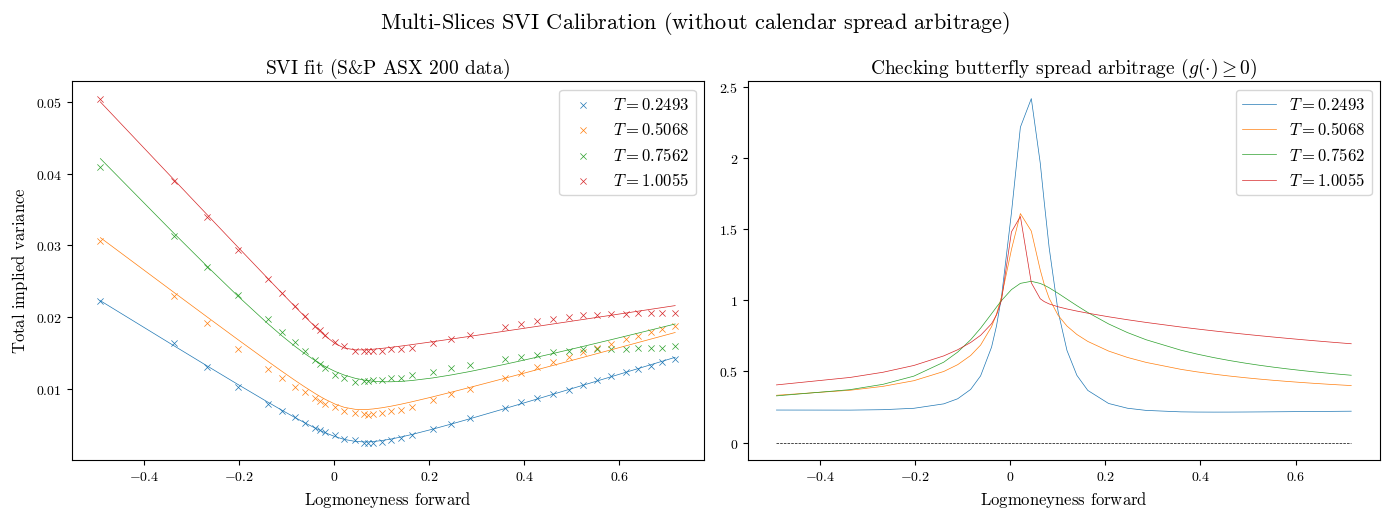

In [47]:
fig, ax = plt.subplots(1, 2, figsize = (7*2, 5.25))

ax[0].scatter(k, maturities[0] * sub_df_1["ImpliedVolatility"]**2, lw = 0.5, marker = "x", s = 20, label = fr"$T = {maturities[0]}$")
ax[0].scatter(k, maturities[1] * sub_df_2["ImpliedVolatility"]**2, lw = 0.5, marker = "x", s = 20, label = fr"$T = {maturities[1]}$")
ax[0].scatter(k, maturities[2] * sub_df_3["ImpliedVolatility"]**2, lw = 0.5, marker = "x", s = 20, label = fr"$T = {maturities[2]}$")
ax[0].scatter(k, maturities[3] * sub_df_4["ImpliedVolatility"]**2, lw = 0.5, marker = "x", s = 20, label = fr"$T = {maturities[3]}$")
ax[0].plot(k, maturities[0] * svi_raw(k, result[0, 0], result[0, 1], result[0, 2], result[0, 3], result[0, 4]), lw = 0.5)
ax[0].plot(k, maturities[1] * svi_raw(k, result[1, 0], result[1, 1], result[1, 2], result[1, 3], result[1, 4]), lw = 0.5)
ax[0].plot(k, maturities[2] * svi_raw(k, result[2, 0], result[2, 1], result[2, 2], result[2, 3], result[2, 4]), lw = 0.5)
ax[0].plot(k, maturities[3] * svi_raw(k, result[3, 0], result[3, 1], result[3, 2], result[3, 3], result[3, 4]), lw = 0.5)
ax[0].set_xlabel(r"$\text{Logmoneyness forward}$", fontsize=12)
ax[0].set_ylabel(r"$\text{Total implied variance}$", fontsize=12)
ax[0].set_title(r"$\text{SVI fit (S\&P ASX 200 data)}$", fontsize=14)
ax[0].legend(fontsize=12)
ax[0].xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
ax[0].yaxis.set_major_formatter(lambda y, _: f"${y:g}$")

ax[1].plot(k, np.zeros_like(k), lw = 0.5, color = "black", linestyle="--")
ax[1].plot(k, durrleman_condition(k, result[0, 0], result[0, 1], result[0, 2], result[0, 3], result[0, 4]), lw = 0.5, label = fr"$T = {maturities[0]}$")
ax[1].plot(k, durrleman_condition(k, result[1, 0], result[1, 1], result[1, 2], result[1, 3], result[1, 4]), lw = 0.5, label = fr"$T = {maturities[1]}$")
ax[1].plot(k, durrleman_condition(k, result[2, 0], result[2, 1], result[2, 2], result[2, 3], result[2, 4]), lw = 0.5, label = fr"$T = {maturities[2]}$")
ax[1].plot(k, durrleman_condition(k, result[3, 0], result[3, 1], result[3, 2], result[3, 3], result[3, 4]), lw = 0.5, label = fr"$T = {maturities[3]}$")
ax[1].set_xlabel(r"$\text{Logmoneyness forward}$", fontsize=12)
ax[1].set_title(r"$\text{Checking butterfly spread arbitrage (} g(\cdot)\geq0\text{)}$", fontsize=14)
ax[1].legend(fontsize=12)
ax[1].xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
ax[1].yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
fig.suptitle(r"$\text{Multi-Slices SVI Calibration (without calendar spread arbitrage)}$", fontsize=16)

plt.tight_layout()
plt.show()

## III. eSSVI

In [23]:
S0, V0, r, kappa, theta, nu, rho = 1, 0.04, 0, 1.5, 0.04, 1.5, -0.75 # r = 0 (so as not to be bothered by forwards)
T_range = np.array([0.5, 1, 2, 5])
K_range = np.array([
    np.linspace(0.80, 1.20, 30),
    np.linspace(0.80, 1.20, 30),
    np.linspace(0.80, 1.20, 30),
    np.linspace(0.80, 1.20, 30),])
IVs = np.zeros((len(T_range), len(K_range[0])))
prices_otm_market = np.zeros((len(T_range), len(K_range[0])))
for i, T in enumerate(T_range) : 
    IVs[i,:] = generate_IV_Heston(T, K_range[i], S0, V0, r, kappa, theta, nu, rho)
    prices_otm_market[i,:] = generate_OTM_prices_Heston(T, K_range[i], S0, V0, r, kappa, theta, nu, rho)

100%|██████████████████████████████████████████| 30/30 [00:00<00:00, 158.03it/s]


In [25]:
k_values = [np.log(K_range[i]) for i in range(len(T_range))]
tvi_market = [IVs[i,:]**2 * T_range[i] for i in range(len(T_range))]
k_star_values = []
theta_star_values = []

for i in range(len(T_range)) : 
    idx = np.argmin(np.abs(np.log(K_range[i])))
    k_star_values.append(np.log(K_range[i])[idx])
    theta_star_values.append(IVs[i, idx]**2 * T_range[i])

k_star_values = np.array(k_star_values)
theta_star_values = np.array(theta_star_values)

In [27]:
essvi = eSSVI(k_values, tvi_market, T_range, k_star_values, theta_star_values)
essvi_2 = eSSVI_2(k_values, T_range, theta_star_values, tvi_market, prices_otm_market)

In [29]:
result = essvi.calibration()
result_2 = essvi_2.calibration()

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


In [35]:
w_ssvi = ssvi2.compute_w(result_2.x)

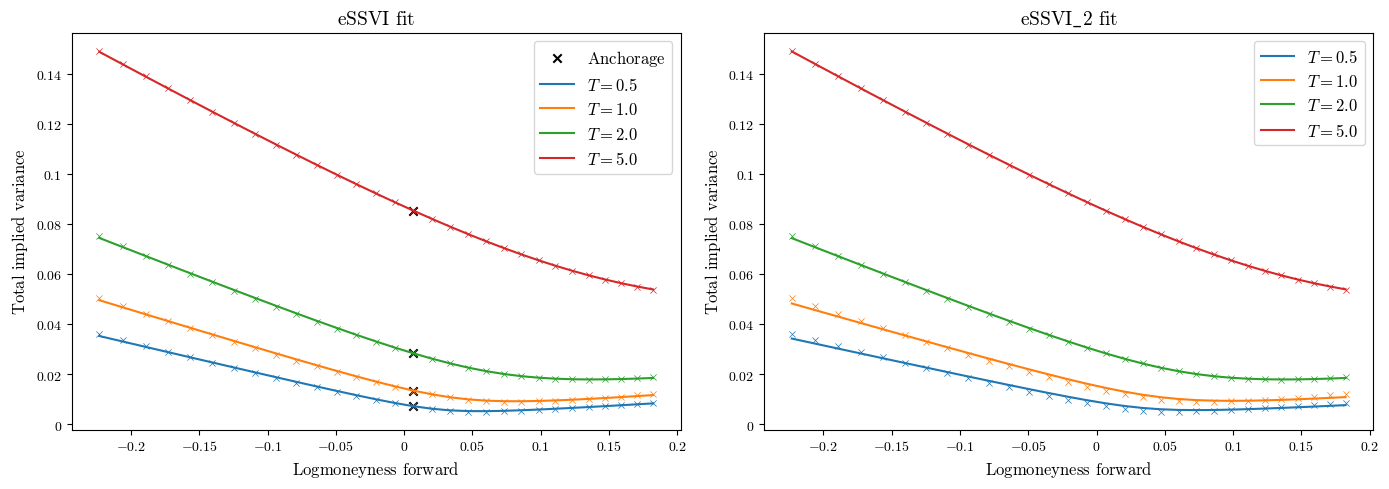

In [58]:
fig, ax = plt.subplots(1, 2, figsize = (7*2, 5))
for i in range(len(T_range)) : 
    ax[0].scatter(k_star_values[i], theta_star_values[i], color = "black", marker ="x") if i > 0 else  ax[0].scatter(k_star_values[i], theta_star_values[i], color = "black", marker ="x", label = r"$\text{Anchorage}$")
    ax[0].plot(k_values[i], tvi_raw(k_values[i], result[i,0], result[i,1], result[i,2]), label = fr"$T = {T_range[i]}$")
    ax[0].scatter(k_values[i], tvi_market[i], s = 20, lw = 0.5, marker = "x")
    ax[1].plot(k_values[i], w_ssvi[i], label = fr"$T = {T_range[i]}$")
    ax[1].scatter(k_values[i], tvi_market[i], s = 20, lw = 0.5, marker = "x")

ax[0].set_xlabel(r"$\text{Logmoneyness forward}$", fontsize=12)
ax[0].set_ylabel(r"$\text{Total implied variance}$", fontsize=12)
ax[1].set_xlabel(r"$\text{Logmoneyness forward}$", fontsize=12)
ax[1].set_ylabel(r"$\text{Total implied variance}$", fontsize=12)
ax[0].set_title(r"$\text{eSSVI fit}$", fontsize=14)
ax[1].set_title(r"$\text{eSSVI}\_\text{2 fit}$", fontsize=14)
ax[0].xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
ax[0].yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
ax[0].legend(fontsize=12)
ax[1].xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
ax[1].yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
ax[1].legend(fontsize=12)

plt.tight_layout()
plt.show()

Note: To be precise, `eSSVI` requires a reliable estimation of $\theta^\star$, which is not always possible depending on the market liquidity.